### Using Pytorch

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import h5py
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import random
from PIL import Image
import glob
from pathlib import Path
from torch.utils import data
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

In [10]:
img_nega= os.listdir("Ischaemia/Aug-Negative")
label_nega = np.zeros(len(img_nega), dtype=int)  # Labels pour les négatifs (0)
img_posi=os.listdir("Ischaemia/Aug-Positive")
label_posi = np.ones(len(img_posi), dtype=int)  # Labels pour les positifs (1)


In [8]:
len(img_posi)

4935

In [11]:
from sklearn.model_selection import train_test_split

# Combiner données et labels
all_images = img_nega + img_posi
all_labels = np.concatenate([label_nega, label_posi])

# Diviser en train+val et test (80% train+val, 20% test)
images_train_val, images_test, labels_train_val, labels_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Diviser train+val en train et val (80% train, 20% val)
images_train, images_val, labels_train, labels_val = train_test_split(
    images_train_val, labels_train_val, test_size=0.25, random_state=42, stratify=labels_train_val
)

# Afficher la répartition des données
print("Nombre d'images d'entraînement :", len(images_train))
print("Nombre d'images de validation :", len(images_val))
print("Nombre d'images de test :", len(images_test))

Nombre d'images d'entraînement : 5922
Nombre d'images de validation : 1974
Nombre d'images de test : 1974


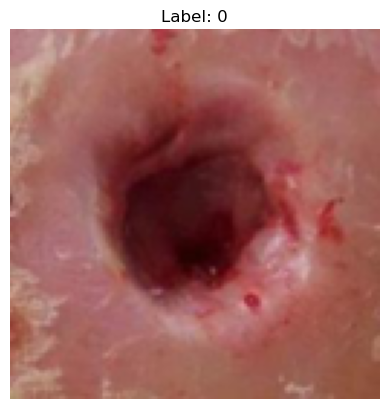

In [ ]:


# 1. Charger les données et étiquettes
img_nega = os.listdir("Ischaemia/Aug-Negative")
label_nega = np.zeros(len(img_nega), dtype=int)

img_posi = os.listdir("Ischaemia/Aug-Positive")
label_posi = np.ones(len(img_posi), dtype=int)

# Ajouter les chemins complets
img_nega = ["Ischaemia/Aug-Negative/" + img for img in img_nega]
img_posi = ["Ischaemia/Aug-Positive/" + img for img in img_posi]

# Combiner les données et les labels
all_images = img_nega + img_posi
all_labels = np.concatenate([label_nega, label_posi])

# Diviser les ensembles (train+val et test, puis train et val)
images_train_val, images_test, labels_train_val, labels_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

images_train, images_val, labels_train, labels_val = train_test_split(
    images_train_val, labels_train_val, test_size=0.25, random_state=42, stratify=labels_train_val
)

# 2. Créer un Dataset personnalisé
class IschaemiaDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Charger l'image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")  # Convertir en RGB

        # Appliquer les transformations (si spécifiées)
        if self.transform:
            image = self.transform(image)

        # Retourner l'image et son label
        label = self.labels[idx]
        return image, label

# 3. Définir des transformations (optionnel)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensionner les images
    transforms.ToTensor(),         # Convertir en tenseur PyTorch
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normaliser
])

# 4. Créer les datasets
train_dataset = IschaemiaDataset(images_train, labels_train, transform=transform)
val_dataset = IschaemiaDataset(images_val, labels_val, transform=transform)
test_dataset = IschaemiaDataset(images_test, labels_test, transform=transform)

# 5. Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 6. Exemple d'utilisation
# Afficher une image et son label
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Visualiser la première image du lot
plt.imshow(images[0].permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Dé-normalisation
plt.title(f"Label: {labels[0].item()}")
plt.axis('off')
plt.show()


In [34]:
images[0].shape

torch.Size([3, 128, 128])

In [43]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self, input_channels=3, input_height=128, input_width=128):
        super(Network, self).__init__()
        # non_constrained layer
        self.conv1 = nn.Conv2d((128,128), 32, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.dropout1 = nn.Dropout(0.5)

        output_height = input_height // 4  # Adjusted to reflect the max pooling
        output_width = input_width // 4  # Adjusted to reflect the max pooling
        fc1_input_size = 64 * output_height * output_width
        self.fc1 = nn.Linear(fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 1)  # Two classes: 0 and 1

        self.classifier = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            self.pool,
            self.conv2,
            nn.ReLU(),
            self.pool,
            self.dropout1,
            nn.Flatten(),
            self.fc1,
            self.fc2,
            nn.Sigmoid()

        )

    def forward(self, x):
        output = self.classifier(x)
        return output


In [ ]:
model = Network()


In [ ]:
# Initialize your model, loss function, and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    # Training loop
    model.train()
    for inputs, labels in train_loader:
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        print(outputs.shape)

        # Reshape labels for the loss calculation
        labels = labels.view(-1, 1).float()

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Update training accuracy statistics
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Calculate training accuracy
    train_accuracy = correct_predictions / total_samples
    average_loss = total_loss / len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0
    val_correct_predictions = 0
    val_total_samples = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            labels = labels.view(-1, 1).float()
            val_loss += criterion(outputs, labels).item()
            predicted = (outputs > 0.5).float()
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)

    # Calculate validation accuracy
    val_accuracy = val_correct_predictions / val_total_samples
    val_loss /= len(val_loader)

    # Display the average loss and accuracy at the end of each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


### Using tensorflow

In [2]:
import os
import csv
import cv2
import numpy as np
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn.cluster as skc
import sklearn.svm as svm
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from sklearn.model_selection import train_test_split



Ischaemia/Aug-Negative/001213_30.jpg 0
Nombre d'images dans le train : 5527
Nombre d'images dans la validation : 2369
Nombre d'images dans le test : 1974


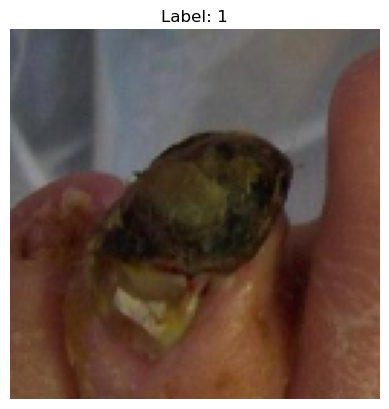

In [ ]:


# 1. Charger les données et étiquettes
img_nega = os.listdir("Ischaemia/Aug-Negative")
label_nega = np.zeros(len(img_nega), dtype=int)

img_posi = os.listdir("Ischaemia/Aug-Positive")
label_posi = np.ones(len(img_posi), dtype=int)

img_nega = ["Ischaemia/Aug-Negative/" + img for img in img_nega]
img_posi = ["Ischaemia/Aug-Positive/" + img for img in img_posi]
all_images = img_nega + img_posi
all_labels = np.concatenate([label_nega, label_posi])

# Diviser 
images_train_val, images_test, labels_train_val, labels_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

images_train, images_val, labels_train, labels_val = train_test_split(
    images_train_val, labels_train_val, test_size=0.3, random_state=42, stratify=labels_train_val
)


print(images_train[5] ,labels_train[5])


def get_data(image_path, labels):
    images = []
    labels_out = []
    for i, img in enumerate(image_path):
        image = cv2.imread(img)  # Charger l'image
        if image is not None:  # Vérifier si l'image a été correctement chargée
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir en RGB
            image = cv2.resize(image, (128, 128)) # Redimensionner (par exemple, à 128x128)
            images.append(image)
            labels_out.append(labels[i])
        else:
            print(f"Erreur lors du chargement de l'image : {img}")

    # Convertir les images et les labels en tableaux NumPy
    images = np.array(images, dtype=np.float32) / 255.0  # Normaliser entre 0 et 1
    labels_out = np.array(labels_out, dtype=np.int32)
    return images, labels_out


# Charger les ensembles de données
train_dataset, train_label = get_data(images_train, labels_train)
val_dataset, val_label = get_data(images_val, labels_val)
test_dataset, test_label = get_data(images_test, labels_test)

# Vérification des tailles des ensembles
print("Nombre d'images dans le train :", len(train_dataset))
print("Nombre d'images dans la validation :", len(val_dataset))
print("Nombre d'images dans le test :", len(test_dataset))






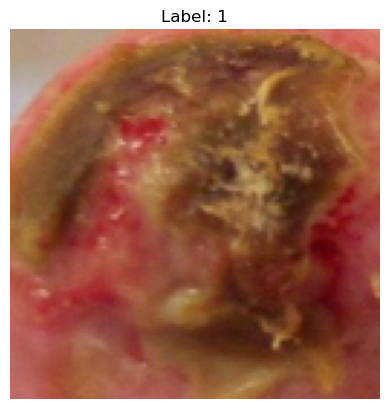

In [21]:
# Visualiser la première image du lot
plt.imshow(test_dataset[3]) 
plt.title(f"Label: {test_label[3].item()}")
plt.axis('off')
plt.show()

In [8]:
print(train_dataset[0].shape)
print(train_dataset[1].shape)
print(train_dataset[7].shape)
print(train_dataset[100].shape)


(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


In [9]:
len(train_label)
len(train_dataset)

5922

model avec 92% test 

In [4]:
inputs = tf.keras.Input(shape=train_dataset[0].shape)

# Preparing the model
# Convolutional Layer #1
conv1 = tf.keras.layers.Conv2D(
    filters=16,
    kernel_size=[7, 7],
    padding="valid",
    activation=tf.nn.relu,
    kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
# Pooling Layer #1
pool1 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv1)

# Convolutional Layer #2
conv2 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=[5, 5],
    padding="valid",
    activation=tf.nn.relu)(pool1)
# Pooling Layer #2
pool2 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv2)
# Convolutional Layer #3
conv3 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=[3, 3],
    padding="valid",
    activation=tf.nn.relu)(pool2)
# Pooling Layer #2
pool3 = tf.keras.layers.MaxPooling2D(pool_size=[2, 2], strides=2)(conv3)

# Flattening and Fully Connected Layers
flat = tf.keras.layers.Flatten()(pool3)
mlp1 = tf.keras.layers.Dense(units=256, activation=tf.nn.relu)(flat)
mlp1 = tf.keras.layers.Dropout(0.3)(mlp1)
mlp = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(mlp1)

# Output Layer for Binary Classification
output_classif = tf.keras.layers.Dense(units=1, activation='sigmoid')(mlp)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=output_classif)

binloss=tf.keras.losses.BinaryCrossentropy()

# Compile the model with binary cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 122, 122, 16)      2368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        18496 

model avec 90% test 

In [26]:
import tensorflow as tf

# Preparing the network input tensor
inputs = tf.keras.Input(shape=train_dataset[0].shape)

# Convolutional Layer #1
conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="valid", activation="relu")(inputs)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(conv1)

# Convolutional Layer #2
conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, padding="valid", activation="relu")(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(conv2)

# Convolutional Layer #3
conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="valid", activation="relu")(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(conv3)

# Flattening and Fully Connected Layers
flat = tf.keras.layers.Flatten()(pool3)
mlp = tf.keras.layers.Dense(units=256, activation="relu")(flat)

# Output Layer for Binary Classification
output_classif = tf.keras.layers.Dense(units=1, activation='sigmoid')(mlp)

# Define the model
model = tf.keras.Model(inputs=inputs, outputs=output_classif)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_23 (Conv2D)          (None, 122, 122, 32)      4736      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 61, 61, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 57, 57, 32)        25632     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 26, 26, 64)        1849

In [5]:


# Entraînement du modèle avec EarlyStopping
history = model.fit(
    train_dataset, train_label,
    validation_data=(val_dataset, val_label),
    epochs=20,
    batch_size=32,
)


Epoch 1/20
173/173 [==============================] - 116s 651ms/step - loss: 0.5175 - accuracy: 0.7724 - val_loss: 0.3799 - val_accuracy: 0.8607
Epoch 2/20
173/173 [==============================] - 68s 394ms/step - loss: 0.3948 - accuracy: 0.8500 - val_loss: 0.3856 - val_accuracy: 0.8569
Epoch 3/20
173/173 [==============================] - 47s 271ms/step - loss: 0.3743 - accuracy: 0.8565 - val_loss: 0.3752 - val_accuracy: 0.8586
Epoch 4/20
173/173 [==============================] - 124s 715ms/step - loss: 0.3426 - accuracy: 0.8743 - val_loss: 0.3749 - val_accuracy: 0.8582
Epoch 5/20
173/173 [==============================] - 123s 710ms/step - loss: 0.3187 - accuracy: 0.8847 - val_loss: 0.3217 - val_accuracy: 0.8772
Epoch 6/20
173/173 [==============================] - 107s 617ms/step - loss: 0.3268 - accuracy: 0.8781 - val_loss: 0.3601 - val_accuracy: 0.8662
Epoch 7/20
173/173 [==============================] - 37s 215ms/step - loss: 0.3019 - accuracy: 0.8900 - val_loss: 0.3093 - va

In [6]:
# Evaluate on train set
train_loss, train_accuracy = model.evaluate(train_dataset, train_label, verbose=0)
print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")

# Evaluate on train set
val_loss, val_accuracy = model.evaluate(val_dataset, val_label, verbose=0)
print(f"val Loss: {val_loss}, val Accuracy: {val_accuracy}")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_dataset, test_label, verbose=0)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


Training Loss: 0.1393972933292389, Training Accuracy: 0.9638140201568604
val Loss: 0.26252052187919617, val Accuracy: 0.9096665382385254
Test Loss: 0.23830725252628326, Test Accuracy: 0.9199594855308533


the test part with random image from the test set

1/1 [==============================] - 0s 22ms/step


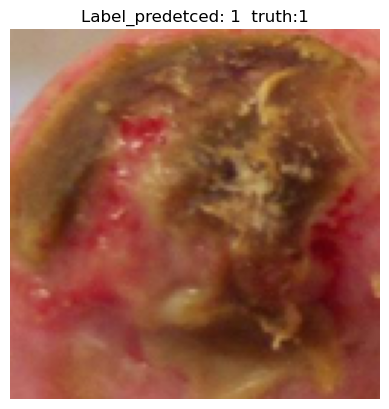

In [ ]:
image_m = np.expand_dims(test_dataset[3], axis=0) # add axe to match the shape of the model 
image=test_dataset[3]
ground_truth=test_label[3]

# Faire la prédiction
prediction = model.predict(image_m) # give probability 
binary_label = 1 if prediction >= 0.5 else 0 #to have binary prediction


# Visualiser la première image du lot
plt.imshow(image) 
plt.title(f"Label_predetced: {binary_label}  truth:{ground_truth}")
plt.axis('off')
plt.show()